<a href="https://colab.research.google.com/github/quanndm/kltn/blob/main/notebooks/demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Init - import library - download data

In [1]:
!rm -rf kltn
!rm -rf sample_data
!git clone -b dev https://github.com/quanndm/kltn.git

Cloning into 'kltn'...
remote: Enumerating objects: 3344, done.
remote: Counting objects: 100% (227/227), done.
remote: Compressing objects: 100% (174/174), done.
remote: Total 3344 (delta 151), reused 98 (delta 53), pack-reused 3117 (from 3)
Receiving objects: 100% (3344/3344), 105.17 MiB | 22.55 MiB/s, done.
Resolving deltas: 100% (2289/2289), done.


In [2]:
from kltn.init.install_dependencies import install_packages, load_config
install_packages("./kltn")
config = load_config("./kltn/parameters.yaml")

In [91]:
import torch
import matplotlib.pyplot as plt
import numpy as np
from google.colab import drive
import json
import pathlib
import re

from kltn import *
from kltn.datasets.lits import Lits, Stage2Dataset2D
from kltn.datasets.get_datasets import get_datasets_lits, convert_to_2D_dataset_v1
from kltn.utils.logger import init_logger
from kltn.utils.train_val_epochs import  trainer_stage1
from kltn.utils.metrics import  DiceMetric, TverskyLossWSigmoid, DiceLossWSigmoid
from kltn.models.model_factory import ModelFactory
from kltn.utils.visualize_results import visualize_results, visualize_results_stage_1, visualize_ct_slice
from kltn.utils.utils import find_best_slice, preprocessing_liver, preprocessing_tumor, predict_and_resize_mask_stage_1, predict_and_resize_mask_stage_2
from kltn.processing.preprocessing import resize_crop_to_bbox_size, uncrop_to_full_image, resize_image, get_bbox_liver, get_liver_roi
from kltn.processing.postprocessing import post_trans_stage1, post_processing_stage2
from skimage.transform import resize

In [4]:
drive.flush_and_unmount()
drive.mount("/content/gdrive")

Drive not mounted, so nothing to flush and unmount.
Mounted at /content/gdrive


In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [6]:
path = "/content/LITS17/"

In [ ]:
from kltn.datasets.prepare_data import prepare_dataset_LiTS
prepare_dataset_LiTS(dir_name=config["source_folder_lits"])

0.00% complete (down: 0.0 kB/s up: 0.0 kB/s peers: 1) downloading LITS17 url seed (http://host1.academictorrents.com/share/) failed: Host not found (authoritative)
LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (udp://tracker.opentrackr.org:1337/announce)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (1)
LITS17 (https://ipv6.academictorrents.com/announce.php)[172.28.0.12:6881] v1 unspecified system error "" (1)
3.59% complete (down: 49571.5 kB/s up: 1458.4 kB/s peers: 9) downloading LITS17 (https://academictorrents.com/announce.php)[127.0.0.1:6881] v1 skipping tracker announce (unreachable) "" (2)
LITS17 (https://ipv6.academictorrents.com/announce.php)[127.0.0.1:6881] v1 s

In [ ]:
!tar -czvf LITS17.tar.gz -C LITS17 .

./
./segmentation-126.nii
./volume-101.nii
./volume-14.nii
./volume-25.nii
./volume-75.nii
./segmentation-118.nii
./volume-7.nii
./volume-8.nii
./volume-28.nii
./segmentation-116.nii
./segmentation-42.nii
./volume-63.nii
./volume-31.nii
./volume-19.nii
./volume-80.nii
./segmentation-6.nii
./volume-67.nii
./volume-61.nii
./volume-116.nii
./segmentation-38.nii
./volume-117.nii
./volume-41.nii
./volume-83.nii
./volume-110.nii
./segmentation-31.nii
./volume-129.nii
./volume-12.nii
./volume-44.nii
./segmentation-106.nii
./segmentation-119.nii
./segmentation-20.nii
./segmentation-27.nii
./segmentation-120.nii
./volume-65.nii
./volume-69.nii
./volume-15.nii
./segmentation-129.nii
./volume-40.nii
./volume-86.nii
./segmentation-49.nii
./segmentation-64.nii
./segmentation-58.nii
./volume-118.nii
./volume-79.nii
./volume-97.nii
./volume-84.nii
./segmentation-107.nii
./volume-11.nii
./volume-0.nii
./segmentation-16.nii
./segmentation-66.nii
./segmentation-68.nii
./volume-46.nii
./volume-126.nii
./

In [ ]:
!mv LITS17.tar.gz /content/gdrive/MyDrive/KLTN/

In [7]:
!cp /content/gdrive/MyDrive/KLTN/LITS17.tar.gz .

In [8]:
!mkdir LITS17
!tar -xzvf LITS17.tar.gz -C LITS17

./
./segmentation-126.nii
./volume-101.nii
./volume-14.nii
./volume-25.nii
./volume-75.nii
./segmentation-118.nii
./volume-7.nii
./volume-8.nii
./volume-28.nii
./segmentation-116.nii
./segmentation-42.nii
./volume-63.nii
./volume-31.nii
./volume-19.nii
./volume-80.nii
./segmentation-6.nii
./volume-67.nii
./volume-61.nii
./volume-116.nii
./segmentation-38.nii
./volume-117.nii
./volume-41.nii
./volume-83.nii
./volume-110.nii
./segmentation-31.nii
./volume-129.nii
./volume-12.nii
./volume-44.nii
./segmentation-106.nii
./segmentation-119.nii
./segmentation-20.nii
./segmentation-27.nii
./segmentation-120.nii
./volume-65.nii
./volume-69.nii
./volume-15.nii
./segmentation-129.nii
./volume-40.nii
./volume-86.nii
./segmentation-49.nii
./segmentation-64.nii
./segmentation-58.nii
./volume-118.nii
./volume-79.nii
./volume-97.nii
./volume-84.nii
./segmentation-107.nii
./volume-11.nii
./volume-0.nii
./segmentation-16.nii
./segmentation-66.nii
./segmentation-68.nii
./volume-46.nii
./volume-126.nii
./

In [ ]:
import json

path_save_result = f"/content/gdrive/MyDrive/KLTN/bbox.json"
def load_json(json_path):
    with open(json_path, 'r') as f:
        return json.load(f)

liver_masks_bbox = load_json(path_save_result)

In [ ]:
convert_to_2D_dataset_v1(source=config["source_folder_lits"], bbox=liver_masks_bbox, slides=3, save_dir=config["path_save_dataset_2D"]) # 3 slide of 3d and stride 2

Patient 45 processed.
Patient 76 processed.
Patient 104 processed.
Patient 22 processed.
Patient 98 processed.
Patient 0 processed.
Patient 27 processed.
Patient 38 processed.
Patient 91 processed.
Patient 39 processed.
Patient 28 processed.
Patient 32 processed.
Patient 125 processed.
Patient 83 processed.
Patient 130 processed.
Patient 75 processed.
Patient 111 processed.
Patient 124 processed.
Patient 4 processed.
Patient 108 processed.
Patient 117 processed.
Patient 61 processed.
Patient 7 processed.
Patient 90 processed.
Patient 110 processed.
Patient 82 processed.
Patient 14 processed.
Patient 101 processed.
Patient 109 processed.
Patient 65 processed.
Patient 62 processed.
Patient 106 processed.
Patient 34 processed.
Patient 126 processed.
Patient 49 processed.
Patient 52 processed.
Patient 23 processed.
Patient 70 processed.
Patient 15 processed.
Patient 24 processed.
Patient 89 processed.
Patient 36 processed.
Patient 9 processed.
Patient 92 processed.
Patient 53 processed.
Pa

In [ ]:
!tar -czf 2D_dataset.tar.gz -C 2D_dataset .

Streaming output truncated to the last 5000 lines.
./patient_110_slice_113.npz
./patient_27_slice_555.npz
./patient_108_slice_211.npz
./patient_111_slice_347.npz
./patient_10_slice_311.npz
./patient_118_slice_299.npz
./patient_124_slice_389.npz
./patient_90_slice_377.npz
./patient_122_slice_137.npz
./patient_103_slice_345.npz
./patient_82_slice_329.npz
./patient_83_slice_865.npz
./patient_4_slice_267.npz
./patient_98_slice_313.npz
./patient_4_slice_147.npz
./patient_5_slice_479.npz
./patient_87_slice_875.npz
./patient_101_slice_341.npz
./patient_94_slice_223.npz
./patient_17_slice_409.npz
./patient_19_slice_397.npz
./patient_27_slice_653.npz
./patient_34_slice_063.npz
./patient_60_slice_209.npz
./patient_71_slice_081.npz
./patient_83_slice_127.npz
./patient_126_slice_393.npz
./patient_95_slice_581.npz
./patient_9_slice_211.npz
./patient_89_slice_467.npz
./patient_109_slice_331.npz
./patient_67_slice_001.npz
./patient_43_slice_043.npz
./patient_117_slice_393.npz
./patient_22_slice_203.n

In [ ]:
!mv 2D_dataset.tar.gz /content/gdrive/MyDrive/KLTN/

In [ ]:
!cp /content/gdrive/MyDrive/KLTN/2D_dataset.tar.gz .

In [ ]:
!mkdir 2D_dataset
!tar -xzvf 2D_dataset.tar.gz -C 2D_dataset

Streaming output truncated to the last 5000 lines.
./patient_110_slice_113.npz
./patient_27_slice_555.npz
./patient_108_slice_211.npz
./patient_111_slice_347.npz
./patient_10_slice_311.npz
./patient_118_slice_299.npz
./patient_124_slice_389.npz
./patient_90_slice_377.npz
./patient_122_slice_137.npz
./patient_103_slice_345.npz
./patient_82_slice_329.npz
./patient_83_slice_865.npz
./patient_4_slice_267.npz
./patient_98_slice_313.npz
./patient_4_slice_147.npz
./patient_5_slice_479.npz
./patient_87_slice_875.npz
./patient_101_slice_341.npz
./patient_94_slice_223.npz
./patient_17_slice_409.npz
./patient_19_slice_397.npz
./patient_27_slice_653.npz
./patient_34_slice_063.npz
./patient_60_slice_209.npz
./patient_71_slice_081.npz
./patient_83_slice_127.npz
./patient_126_slice_393.npz
./patient_95_slice_581.npz
./patient_9_slice_211.npz
./patient_89_slice_467.npz
./patient_109_slice_331.npz
./patient_67_slice_001.npz
./patient_43_slice_043.npz
./patient_117_slice_393.npz
./patient_22_slice_203.n

In [86]:
import os
import re

def find_closest_slice_file(folder, target_slice, mode="nearest"):
    # Lấy danh sách tất cả file có tên dạng slice_xxx.npz
    files = [f for f in os.listdir(folder) if f.endswith(".npz")]

    # Trích số slice từ tên file
    slice_map = {}
    for file in files:
        match = re.search(r'slice-(\d+)', file)
        if match:
            slice_num = int(match.group(1))
            slice_map[slice_num] = file

    slice_nums = sorted(slice_map.keys())

    if mode == "nearest":
        closest = min(slice_nums, key=lambda x: abs(x - target_slice))
    elif mode == "before":
        closest = max([x for x in slice_nums if x <= target_slice], default=None)
    elif mode == "after":
        closest = min([x for x in slice_nums if x >= target_slice], default=None)
    else:
        raise ValueError("Mode phải là 'nearest', 'before' hoặc 'after'.")

    if closest is None:
        return None  # Không tìm được file phù hợp
    return closest, os.path.join(folder, slice_map[closest])


## Input image 3D

In [10]:
index_1 = 4
image_1 = Lits.load_nii(f"{path}/volume-{index_1}.nii")
mask_1 = Lits.load_nii(f"{path}/segmentation-{index_1}.nii")

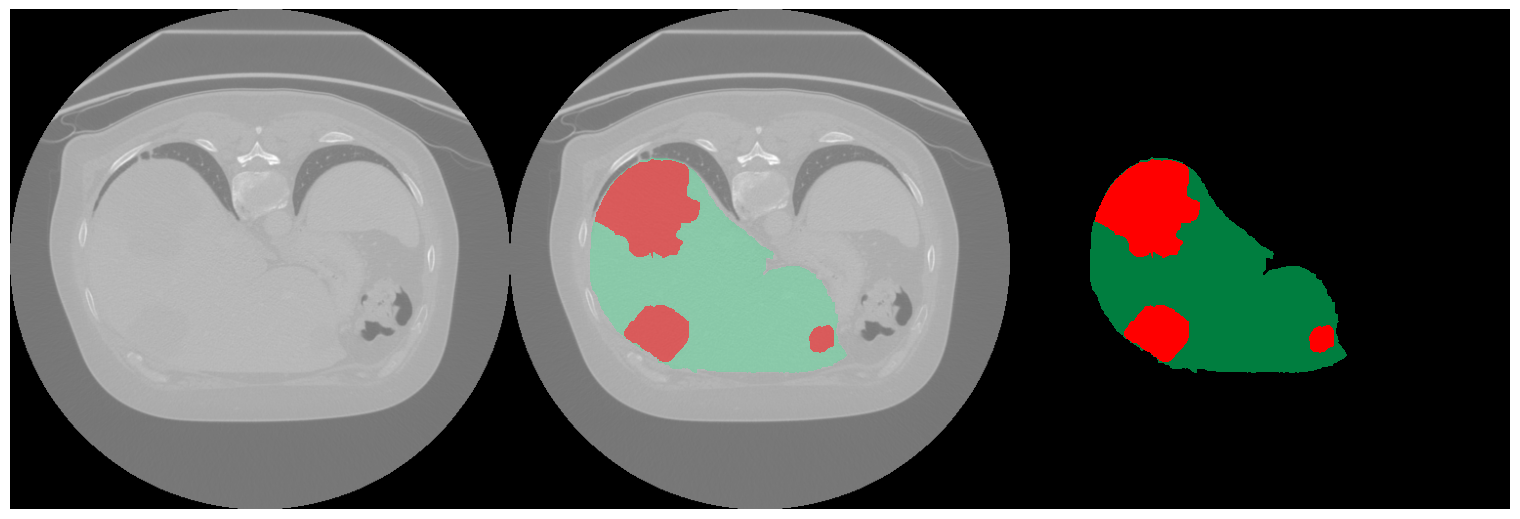

In [11]:
best_slide = find_best_slice(image_1, mask_1)
# print("best slide: ", best_slide)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide,  ax=axes[0])
visualize_ct_slice(image_1, mask_1, slice_index=best_slide, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, mask_1, slice_index=best_slide, tumor=False, alpha=1,  ax=axes[2])

In [13]:
index_2 = 16
image_2 = Lits.load_nii(f"{path}/volume-{index_2}.nii")
mask_2 = Lits.load_nii(f"{path}/segmentation-{index_2}.nii")

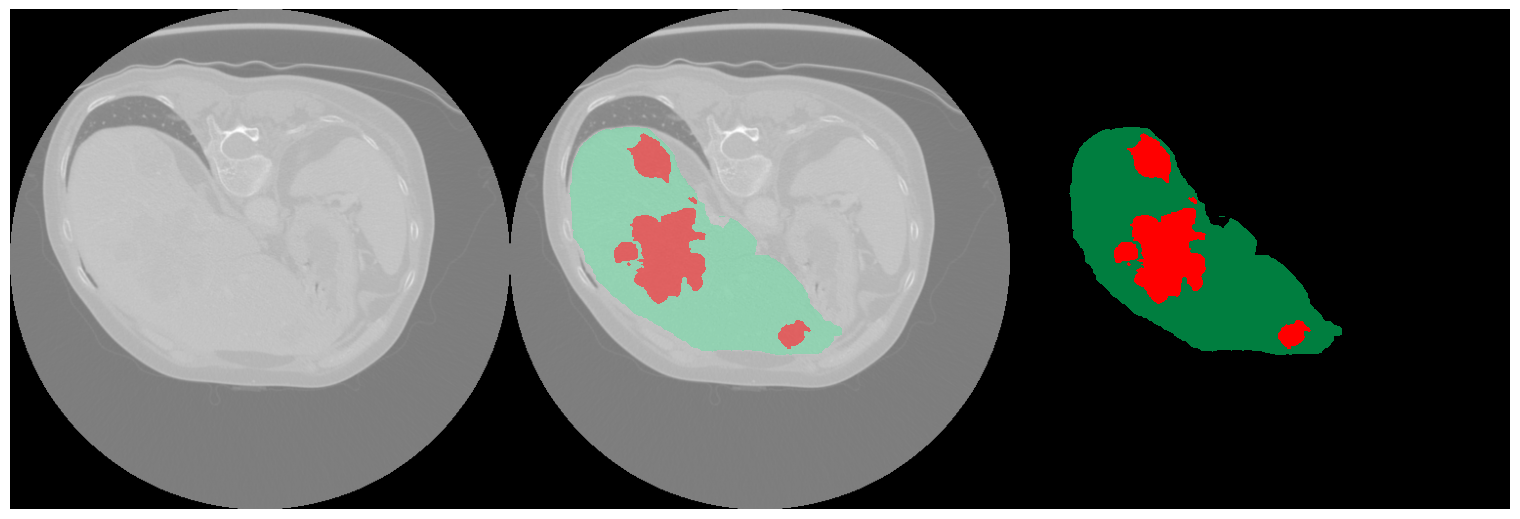

In [14]:
best_slide = find_best_slice(image_2, mask_2)
# print("best slide: ", best_slide)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image_2, None, slice_index=best_slide,  ax=axes[0])
visualize_ct_slice(image_2, mask_2, slice_index=best_slide, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, mask_2, slice_index=best_slide, tumor=False, alpha=1,  ax=axes[2])

## preprocessing & augmentation 3D

In [44]:
index_1 = 4
image_1 = Lits.load_nii(f"{path}/volume-{index_1}.nii")
mask_1 = Lits.load_nii(f"{path}/segmentation-{index_1}.nii")

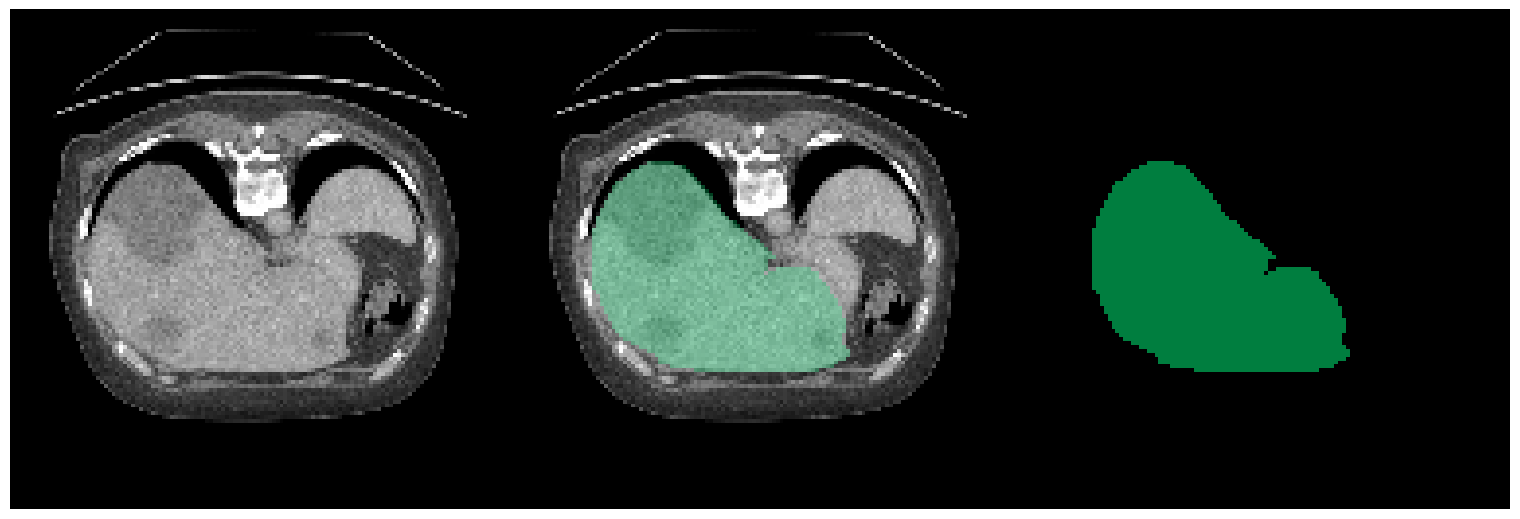

In [45]:
image_1, mask_1 = Lits.preprocessing(image_1, mask_1, False, "zscores") # clip HU, zscore normalization, resize to 128x128x128
image_1, mask_1 = image_1.squeeze(0), mask_1.squeeze(0)
mask_1 = (mask_1 > 0).astype(np.uint8) # convert mask to binary (full liver mask)
best_slide = find_best_slice(image_1, mask_1)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide,  ax=axes[0])
visualize_ct_slice(image_1, mask_1, slice_index=best_slide, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, mask_1, slice_index=best_slide, tumor=False, alpha=1,  ax=axes[2])

In [46]:
index_1 = 4
image_1 = Lits.load_nii(f"{path}/volume-{index_1}.nii")
mask_1 = Lits.load_nii(f"{path}/segmentation-{index_1}.nii")

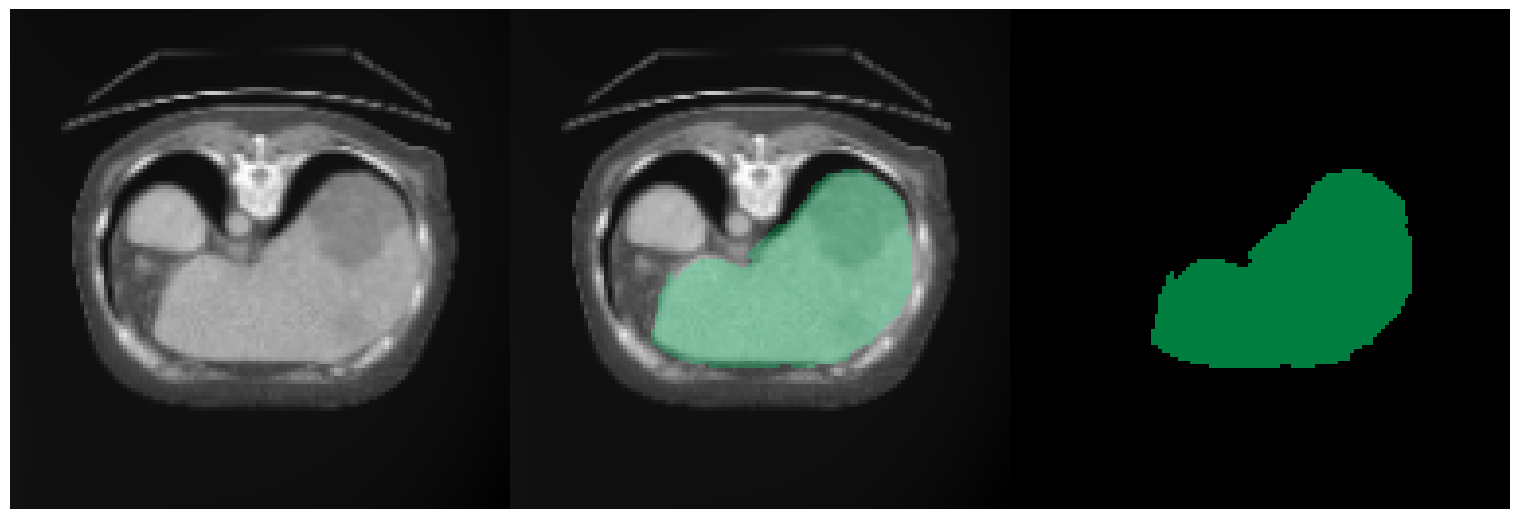

In [48]:
image_1, mask_1 = Lits.preprocessing(image_1, mask_1, False, "zscores") # clip HU, zscore normalization, resize to 128x128x128
image_1, mask_1 = Lits.augmentation(image_1, mask_1) # augmentation
image_1, mask_1 = image_1.squeeze(), mask_1.squeeze()
mask_1 = (mask_1 > 0).astype(np.uint8) # convert mask to binary (full liver mask)
# best_slide = find_best_slice(image_1, mask_1)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide,  ax=axes[0])
visualize_ct_slice(image_1, mask_1, slice_index=best_slide, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, mask_1, slice_index=best_slide, tumor=False, alpha=1,  ax=axes[2])

## Predict Liver

In [115]:
weight_liver = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet_liver_mcb.pth"
model_liver = ModelFactory.get_model("unet3d_resnextcot_mcb",in_channels=1, n_classes=1, n_channels=16).to(device)
model_liver.load_state_dict(torch.load(weight_liver))

<All keys matched successfully>

In [152]:
index_1 = 4
image_1 = Lits.load_nii(f"{path}/volume-{index_1}.nii")
mask_1 = Lits.load_nii(f"{path}/segmentation-{index_1}.nii")

best_slide_1 = find_best_slice(image_1, mask_1)
_, seg_liver = predict_and_resize_mask_stage_1(model_liver, image_1, mask_1)
mask_full_liver = (mask_1 > 0).astype(np.uint8)

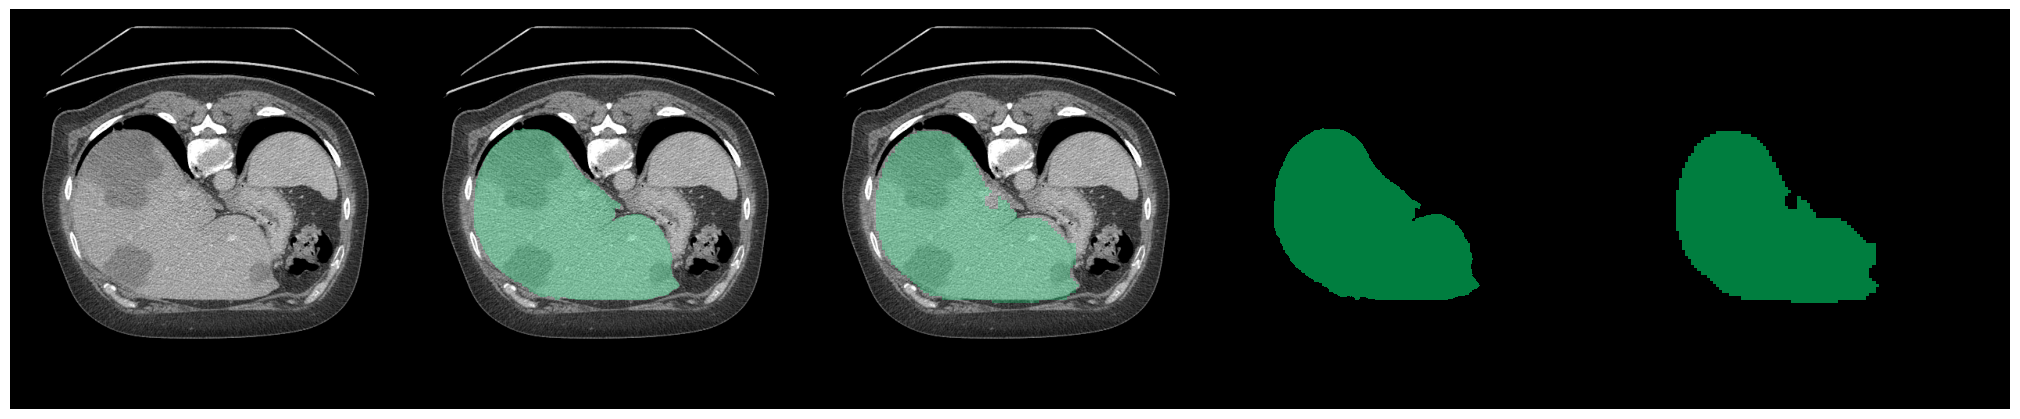

In [119]:
image_1 = np.clip(image_1, -200, 250)

fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_visible(False)
visualize_ct_slice(image_1, None, slice_index=best_slide_1,  ax=axes[0])
visualize_ct_slice(image_1, mask_full_liver, slice_index=best_slide_1, tumor=False, alpha=0.5,  ax=axes[1])
visualize_ct_slice(image_1, seg_liver, slice_index=best_slide_1, tumor=False, alpha=0.5,  ax=axes[2])
visualize_ct_slice(None, mask_full_liver, slice_index=best_slide_1, tumor=False, alpha=1,  ax=axes[3])
visualize_ct_slice(None, seg_liver, slice_index=best_slide_1, tumor=False, alpha=1,  ax=axes[4])

## Crop ROI

In [141]:
!rm -rf 2D_dataset/

In [142]:
!mkdir -p /content/2D_dataset

In [153]:
bbox_liver_1 = get_bbox_liver(seg_liver, margin = 12)
slides = 3
stride = 2
radius = slides // 2
D, H, W = image_1.shape
image_1, seg_1 = get_liver_roi(image_1, mask_1, bbox_liver_1)
for z in range(radius, D - radius, stride):
    image_slides = image_1[z - radius:z + radius + 1, :, :]
    seg_slides = seg_1[z - radius:z + radius + 1, :, :].astype(np.uint8)
    np.savez_compressed(f"/content/2D_dataset/patient-{index_1}_slice-{z}.npz", image=image_slides, seg =  seg_slides, bbox = bbox_liver_1)
    print(f"Saved slices {z - radius} to {z + radius} for volume-{index_1}")

Saved slices 0 to 2 for volume-4
Saved slices 2 to 4 for volume-4
Saved slices 4 to 6 for volume-4
Saved slices 6 to 8 for volume-4
Saved slices 8 to 10 for volume-4
Saved slices 10 to 12 for volume-4
Saved slices 12 to 14 for volume-4
Saved slices 14 to 16 for volume-4
Saved slices 16 to 18 for volume-4
Saved slices 18 to 20 for volume-4
Saved slices 20 to 22 for volume-4
Saved slices 22 to 24 for volume-4
Saved slices 24 to 26 for volume-4
Saved slices 26 to 28 for volume-4
Saved slices 28 to 30 for volume-4
Saved slices 30 to 32 for volume-4
Saved slices 32 to 34 for volume-4
Saved slices 34 to 36 for volume-4
Saved slices 36 to 38 for volume-4
Saved slices 38 to 40 for volume-4
Saved slices 40 to 42 for volume-4
Saved slices 42 to 44 for volume-4
Saved slices 44 to 46 for volume-4
Saved slices 46 to 48 for volume-4
Saved slices 48 to 50 for volume-4
Saved slices 50 to 52 for volume-4
Saved slices 52 to 54 for volume-4
Saved slices 54 to 56 for volume-4
Saved slices 56 to 58 for vol

In [144]:
print("best slide: ", best_slide_1)
closet_index, patient_1_path = find_closest_slice_file("/content/2D_dataset", best_slide_1, mode="before")
print(closet_index, patient_1_path)


best slide:  508
507 /content/2D_dataset/patient-4_slice-507.npz


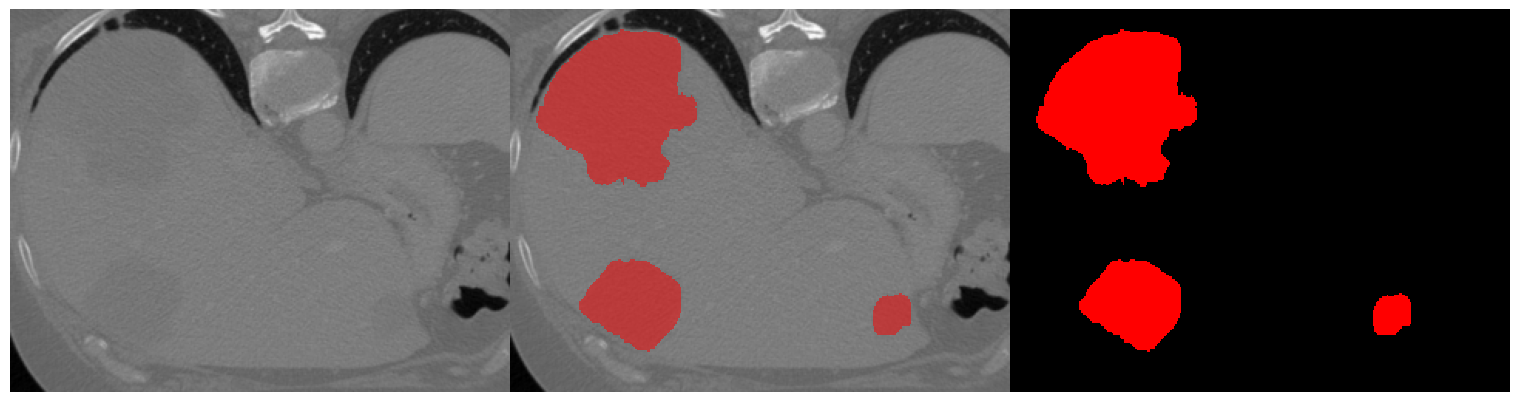

In [154]:
data = Stage2Dataset2D.load_npz(patient_1_path)
_image, _seg, bbox = data["image"], data["seg"], data["bbox"]
image1, seg1 = _image.astype(np.float32), (_seg == 2).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image1, None, tumor=False, alpha=0.5,  ax=axes[0])
visualize_ct_slice(image1, seg1, tumor=True, slice_index = 1, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, seg1, slice_index=1, tumor=True, alpha=1,  ax=axes[2])

## preprocessing &  augmentation 2D

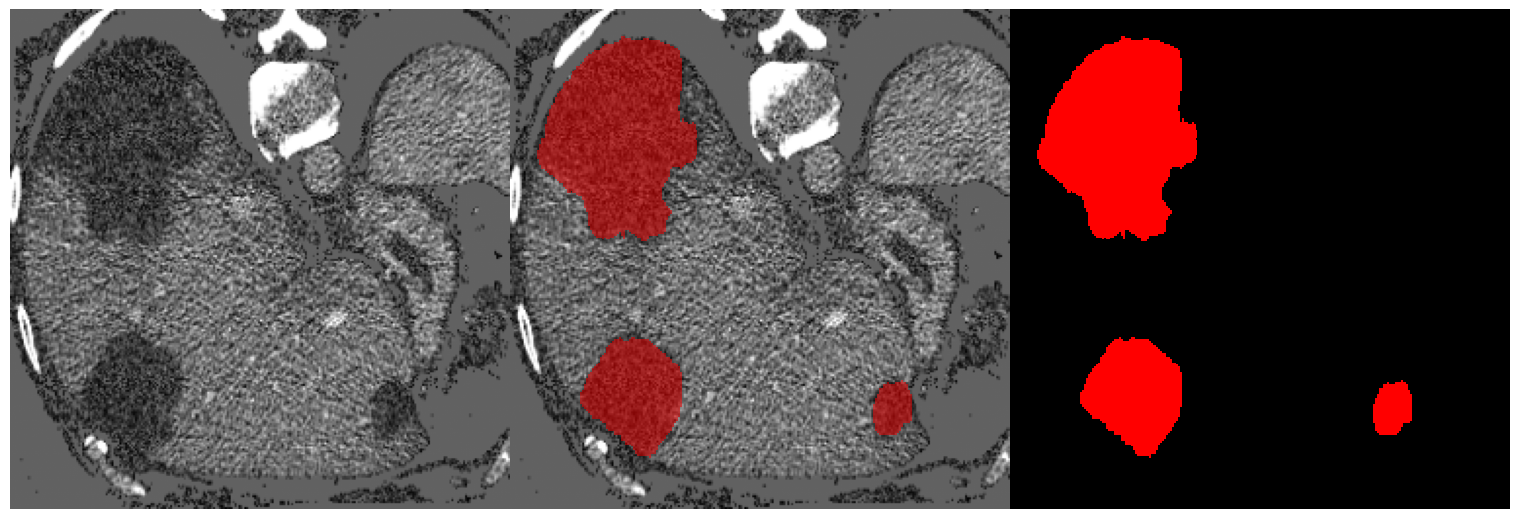

In [155]:
data = Stage2Dataset2D.load_npz(patient_1_path)
_image, _seg, bbox = data["image"], data["seg"], data["bbox"]

image1, seg1 = Stage2Dataset2D.preprocessing(_image, _seg, False, "zscores") # clip HU 0:200, zscores norm, 3x256x256
image1, seg1 = image1.astype(np.float32), (seg1 == 2).astype(np.uint8)


fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image1, None, tumor=False, alpha=0.5,  ax=axes[0])
visualize_ct_slice(image1, seg1, tumor=True, slice_index = 1, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, seg1, slice_index=1, tumor=True, alpha=1,  ax=axes[2])

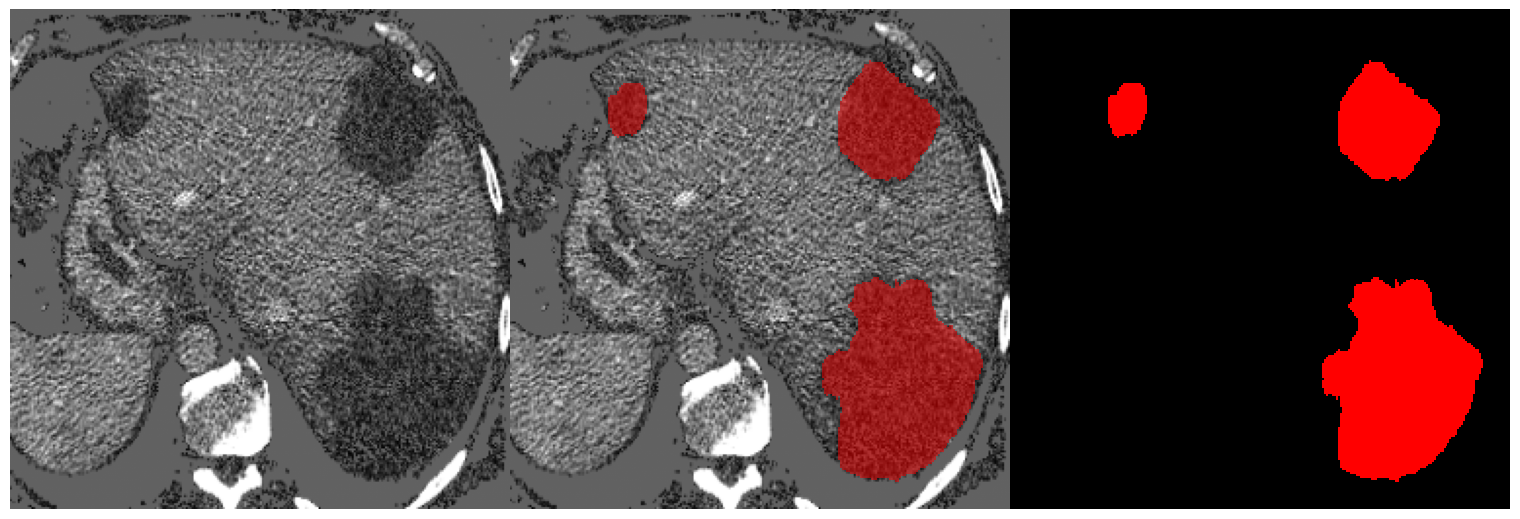

In [159]:
data = Stage2Dataset2D.load_npz(patient_1_path)
_image, _seg, bbox = data["image"], data["seg"], data["bbox"]

image1, seg1 = Stage2Dataset2D.preprocessing(_image, _seg, False, "zscores")
image1, seg1 = np.expand_dims(image1, axis=0), np.expand_dims(seg1, axis=0)
image1, seg1 = Stage2Dataset2D.augmentation(image1, seg1)
image1, seg1 =  image1.cpu().numpy().squeeze(0), seg1.squeeze(0)
image1, seg1 = image1.astype(np.float32), (seg1 == 2).astype(np.uint8)

fig, axes = plt.subplots(1, 3, figsize=(15, 5))
fig.patch.set_visible(False)
visualize_ct_slice(image1, None, tumor=False, alpha=0.5,  ax=axes[0])
visualize_ct_slice(image1, seg1, tumor=True, slice_index = 1, alpha=0.5,  ax=axes[1])
visualize_ct_slice(None, seg1, slice_index=1, tumor=True, alpha=1,  ax=axes[2])

## Predict tumor

In [160]:
weight_tumor = "/content/gdrive/MyDrive/KLTN/code/weight/best_metric_model_MSC_CoTNeXtUNet2D_tumor_mcb.pth"
model_tumor = ModelFactory.get_model("unet2d_resnextcot_mcb",in_channels=3, n_classes=1, n_channels=32).to(device)
model_tumor.load_state_dict(torch.load(weight_tumor))

<All keys matched successfully>

In [161]:
data = Stage2Dataset2D.load_npz(patient_1_path)
_image, _seg, bbox = data["image"], data["seg"], data["bbox"]

In [ ]:
index_1 = 4
image_1 = Lits.load_nii(f"{path}/volume-{index_1}.nii")
mask_1 = Lits.load_nii(f"{path}/segmentation-{index_1}.nii")

In [168]:
full_tumor_mask_pred_1 = predict_and_resize_mask_stage_2(model_tumor, patient_1_path, image_1[closet_index].shape)
mask_full_tumor_1= (mask_1 == 2).astype(np.uint8)

In [ ]:
fig, axes = plt.subplots(1, 5, figsize=(20, 4))
fig.patch.set_visible(False)

visualize_ct_slice(image_1, None, slice_index=closet_index,  ax=axes[0])
visualize_ct_slice(image_1, mask_full_tumor_1, slice_index=closet_index, tumor=True,alpha=0.5,  ax=axes[1])
visualize_ct_slice(np.expand_dims(image_1[closet_index], axis=0), full_tumor_mask_pred_1, tumor=True, alpha=0.5,  ax=axes[2])
visualize_ct_slice(None, mask_full_tumor_1, slice_index=closet_index, tumor=True, alpha=1,  ax=axes[3])
visualize_ct_slice(None, full_tumor_mask_pred_1, slice_index=0, tumor=True, alpha=1,  ax=axes[4])